In [27]:
#
# NOTE: This machine learning program is for predicting TC formation, using
#       input dataset in the NETCDF format. The program treats different
#       2D input fields as different channels of an image. This specific
#       program requires a set of 12 2D-variables (12-channel image) and
#       consists of three stages
#       - Stage 1: reading NETCDF input and generating (X,y) data with a
#                  given image sizes, which are then saved by pickle;
#       - Stage 2: import the saved pickle (X,y) pair and build a CNN model
#                  with a given training/validation ratio, and then save
#                  the train model under tcg_CNN.model.
#       - Stage 3: import the trained model from Stage 2, and make a list
#                  of prediction from normalized test data.
#
# INPUT: This Stage 2 script requires two specific input datasets that are
#        generated from Step 1, including
#        1. tcg_X.pickle: data contains all images of yes/no TCG events, each
#           of these images must have 12 channels
#        2. tcg_y.pickle: data contains all labels of each image (i.e., yes
#           or no) of TCG corresponding to each data in X.
#
#        Remarks: Note that each channel must be normalized separealy. Also
#        the script requires a large memory allocation. So users need to have
#        GPU version to run this.
#
# OUTPUT: A CNN model built from Keras saved under tcg_CNN.model
#
# HIST: - 27, Oct 22: Created by CK
#       - 01, Nov 22: Modified to include more channels
#       - 17, Nov 23: cusomize it for jupiter notebook
#       - 21, Feb 23: use functional model instead of sequential model  
#
# AUTH: Chanh Kieu (Indiana University, Bloomington. Email: ckieu@iu.edu)
#
#==========================================================================
import tensorflow as tf
import numpy as np
import pickle
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard

In [28]:
#
# read in data output from Part 1
#
pickle_in = open("tcg_X.pickle","rb")
X = pickle.load(pickle_in)
pickle_in = open("tcg_y.pickle","rb")
y = pickle.load(pickle_in)
y = np.array(y)
number_channels=X.shape[3]
print('Input shape of the X features data: ',X.shape)
print('Input shape of the y label data: ',y.shape)
print('Number of input channel extracted from X is: ',number_channels)
#
# normalize the data before training the model
#
nsample = X.shape[0]
for i in range(nsample):
    for var in range(number_channels):    
        maxvalue = X[i,:,:,var].flat[np.abs(X[i,:,:,var]).argmax()]
        #print('Normalization factor for sample and channel',i,var,', is: ',abs(maxvalue))
        X[i,:,:,var] = X[i,:,:,var]/abs(maxvalue)
        maxnew = X[i,:,:,var].flat[np.abs(X[i,:,:,var]).argmax()]
        #print('-->After normalization of sample and channel',i,var,', is: ',abs(maxnew))
        #input('Enter to continue...')
print("Finish normalization...")

Input shape of the X features data:  (24, 30, 30, 12)
Input shape of the y label data:  (24,)
Number of input channel extracted from X is:  12
Finish normalization...


In [5]:
#
# test a range of loop for hyperparameter tuning. This is a test and have no impact to the rest of the
# code. 
#
dense_layers = [0, 5]
layer_sizes = [128, 256]
conv_layers = [3, 5]
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            print(dense_layer, layer_size, conv_layer, X.shape[1:])

0 128 3 (30, 30, 12)
0 128 5 (30, 30, 12)
0 256 3 (30, 30, 12)
0 256 5 (30, 30, 12)
5 128 3 (30, 30, 12)
5 128 5 (30, 30, 12)
5 256 3 (30, 30, 12)
5 256 5 (30, 30, 12)


In [35]:
#
# build a range of CNN models with different number of dense layers, layer sizes
# convolution layers to optimize the performance
#
dense_layers = [0]
layer_sizes = [32]
conv_layers = [3]
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print('--> Running configuration: ',NAME)

            inputs = keras.Input(shape=X.shape[1:])            
            x = layers.Conv2D(filters=layer_size,kernel_size=conv_layer,activation="relu",name="my_conv2d_1")(inputs)
            x = layers.MaxPooling2D(pool_size=2,name="my_pooling_1")(x)
            x = layers.Conv2D(filters=layer_size*2,kernel_size=conv_layer,activation="relu",name="my_conv2d_2")(x)
            x = layers.MaxPooling2D(pool_size=2,name="my_pooling_2")(x)
            x = layers.Conv2D(filters=layer_size*4,kernel_size=conv_layer,activation="relu",name="my_conv2d_3")(x)
            x = layers.MaxPooling2D(pool_size=2,name="my_pooling_3")(x)
            #x = layers.Conv2D(filters=256,kernel_size=conv_layer,activation="relu",name="my_conv2d_4")(x)
            #x = layers.MaxPooling2D(pool_size=2,name="my_pooling_4")(x)
            #x = layers.Conv2D(filters=256,kernel_size=conv_layer,activation="relu",name="my_conv2d_5")(x)
            x = layers.Flatten(name="my_flatten")(x)
            outputs = layers.Dense(1,activation="sigmoid",name="my_dense")(x)
            model = keras.Model(inputs=inputs,outputs=outputs,name="my_TCG_model")
            model.summary()
            keras.utils.plot_model(model)
            
            callbacks=[keras.callbacks.ModelCheckpoint("tcg_CNN.model",save_best_only=True)]
            model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
            history = model.fit(X, y, batch_size=90, epochs=30, validation_split=0.1, callbacks=callbacks)
            
            '''
            model = Sequential()
            model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:],data_format="channels_last"))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            tensorboard = TensorBoard(log_dir="./logs/{}".format(NAME))

            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'])

            model.fit(X, y, batch_size=90, epochs=30, validation_split=0.1, callbacks=[tensorboard])'''
            
#
# save the model for the final step
#
#model.save('tcg_CNN.model')

--> Running configuration:  3-conv-32-nodes-0-dense-1677016572
Model: "my_TCG_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 30, 30, 12)]      0         
                                                                 
 my_conv2d_1 (Conv2D)        (None, 28, 28, 32)        3488      
                                                                 
 my_pooling_1 (MaxPooling2D)  (None, 14, 14, 32)       0         
                                                                 
 my_conv2d_2 (Conv2D)        (None, 12, 12, 64)        18496     
                                                                 
 my_pooling_2 (MaxPooling2D)  (None, 6, 6, 64)         0         
                                                                 
 my_conv2d_3 (Conv2D)        (None, 4, 4, 128)         73856     
                                                         

INFO:tensorflow:Assets written to: tcg_CNN.model/assets


INFO:tensorflow:Assets written to: tcg_CNN.model/assets


1/1 [==============================] - 1s 1s/step - loss: 0.6893 - accuracy: 0.4286 - val_loss: 1.2805 - val_accuracy: 0.0000e+00
Epoch 2/30
1/1 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5714

INFO:tensorflow:Assets written to: tcg_CNN.model/assets


INFO:tensorflow:Assets written to: tcg_CNN.model/assets


1/1 [==============================] - 1s 594ms/step - loss: 0.6903 - accuracy: 0.5714 - val_loss: 0.9020 - val_accuracy: 0.0000e+00
Epoch 3/30
1/1 [==============================] - ETA: 0s - loss: 0.5894 - accuracy: 0.5714

INFO:tensorflow:Assets written to: tcg_CNN.model/assets


INFO:tensorflow:Assets written to: tcg_CNN.model/assets


1/1 [==============================] - 1s 668ms/step - loss: 0.5894 - accuracy: 0.5714 - val_loss: 0.5637 - val_accuracy: 1.0000
Epoch 4/30
1/1 [==============================] - ETA: 0s - loss: 0.5480 - accuracy: 0.9524

INFO:tensorflow:Assets written to: tcg_CNN.model/assets


INFO:tensorflow:Assets written to: tcg_CNN.model/assets


1/1 [==============================] - 1s 594ms/step - loss: 0.5480 - accuracy: 0.9524 - val_loss: 0.4879 - val_accuracy: 1.0000
Epoch 5/30
1/1 [==============================] - 0s 27ms/step - loss: 0.4984 - accuracy: 0.9048 - val_loss: 0.6120 - val_accuracy: 0.6667
Epoch 6/30
1/1 [==============================] - 0s 23ms/step - loss: 0.4243 - accuracy: 1.0000 - val_loss: 0.7582 - val_accuracy: 0.6667
Epoch 7/30
1/1 [==============================] - 0s 25ms/step - loss: 0.3871 - accuracy: 0.9048 - val_loss: 0.6692 - val_accuracy: 0.6667
Epoch 8/30
1/1 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.9048

INFO:tensorflow:Assets written to: tcg_CNN.model/assets


INFO:tensorflow:Assets written to: tcg_CNN.model/assets


1/1 [==============================] - 1s 1s/step - loss: 0.3249 - accuracy: 0.9048 - val_loss: 0.4239 - val_accuracy: 0.6667
Epoch 9/30
1/1 [==============================] - ETA: 0s - loss: 0.2598 - accuracy: 1.0000

INFO:tensorflow:Assets written to: tcg_CNN.model/assets


INFO:tensorflow:Assets written to: tcg_CNN.model/assets


1/1 [==============================] - 1s 875ms/step - loss: 0.2598 - accuracy: 1.0000 - val_loss: 0.2756 - val_accuracy: 1.0000
Epoch 10/30
1/1 [==============================] - 0s 26ms/step - loss: 0.2278 - accuracy: 1.0000 - val_loss: 0.2909 - val_accuracy: 1.0000
Epoch 11/30
1/1 [==============================] - 0s 24ms/step - loss: 0.1752 - accuracy: 1.0000 - val_loss: 0.4074 - val_accuracy: 0.6667
Epoch 12/30
1/1 [==============================] - 0s 26ms/step - loss: 0.1412 - accuracy: 1.0000 - val_loss: 0.4350 - val_accuracy: 0.6667
Epoch 13/30
1/1 [==============================] - 0s 23ms/step - loss: 0.1197 - accuracy: 1.0000 - val_loss: 0.2959 - val_accuracy: 0.6667
Epoch 14/30
1/1 [==============================] - ETA: 0s - loss: 0.0852 - accuracy: 1.0000

INFO:tensorflow:Assets written to: tcg_CNN.model/assets


INFO:tensorflow:Assets written to: tcg_CNN.model/assets


1/1 [==============================] - 1s 609ms/step - loss: 0.0852 - accuracy: 1.0000 - val_loss: 0.1651 - val_accuracy: 1.0000
Epoch 15/30
1/1 [==============================] - ETA: 0s - loss: 0.0706 - accuracy: 1.0000

INFO:tensorflow:Assets written to: tcg_CNN.model/assets


INFO:tensorflow:Assets written to: tcg_CNN.model/assets


1/1 [==============================] - 1s 598ms/step - loss: 0.0706 - accuracy: 1.0000 - val_loss: 0.1365 - val_accuracy: 1.0000
Epoch 16/30
1/1 [==============================] - 0s 28ms/step - loss: 0.0560 - accuracy: 1.0000 - val_loss: 0.1873 - val_accuracy: 1.0000
Epoch 17/30
1/1 [==============================] - 0s 26ms/step - loss: 0.0370 - accuracy: 1.0000 - val_loss: 0.2661 - val_accuracy: 0.6667
Epoch 18/30
1/1 [==============================] - 0s 24ms/step - loss: 0.0306 - accuracy: 1.0000 - val_loss: 0.2684 - val_accuracy: 0.6667
Epoch 19/30
1/1 [==============================] - 0s 25ms/step - loss: 0.0239 - accuracy: 1.0000 - val_loss: 0.1817 - val_accuracy: 1.0000
Epoch 20/30
1/1 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 1.0000

INFO:tensorflow:Assets written to: tcg_CNN.model/assets


INFO:tensorflow:Assets written to: tcg_CNN.model/assets


1/1 [==============================] - 1s 608ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0970 - val_accuracy: 1.0000
Epoch 21/30
1/1 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 1.0000

INFO:tensorflow:Assets written to: tcg_CNN.model/assets


INFO:tensorflow:Assets written to: tcg_CNN.model/assets


1/1 [==============================] - 1s 597ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0536 - val_accuracy: 1.0000
Epoch 22/30
1/1 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 1.0000

INFO:tensorflow:Assets written to: tcg_CNN.model/assets


INFO:tensorflow:Assets written to: tcg_CNN.model/assets


1/1 [==============================] - 1s 938ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.0390 - val_accuracy: 1.0000
Epoch 23/30
1/1 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 1.0000

INFO:tensorflow:Assets written to: tcg_CNN.model/assets


INFO:tensorflow:Assets written to: tcg_CNN.model/assets


1/1 [==============================] - 1s 601ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0387 - val_accuracy: 1.0000
Epoch 24/30
1/1 [==============================] - 0s 28ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0470 - val_accuracy: 1.0000
Epoch 25/30
1/1 [==============================] - 0s 26ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0611 - val_accuracy: 1.0000
Epoch 26/30
1/1 [==============================] - 0s 23ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0773 - val_accuracy: 1.0000
Epoch 27/30
1/1 [==============================] - 0s 26ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0892 - val_accuracy: 1.0000
Epoch 28/30
1/1 [==============================] - 0s 26ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0914 - val_accuracy: 1.0000
Epoch 29/30
1/1 [==============================] - 0s 23ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0827 - val_accuracy: 1.0000
Epoch 30/30
1/1 [==============

{'validation_data': None, 'model': <keras.engine.functional.Functional object at 0x2ae602e40670>, '_chief_worker_only': None, '_supports_tf_logs': False, 'history': {'loss': [0.6893151998519897, 0.6903136372566223, 0.5894260406494141, 0.5479647517204285, 0.4984433650970459, 0.42434191703796387, 0.38708946108818054, 0.3249386250972748, 0.2598164677619934, 0.22782225906848907, 0.1751927137374878, 0.14122381806373596, 0.11972656846046448, 0.08523750305175781, 0.0706387311220169, 0.055967461317777634, 0.03703024983406067, 0.03055713325738907, 0.023933155462145805, 0.0148340268060565, 0.01022348552942276, 0.00876737479120493, 0.006889680400490761, 0.004426881205290556, 0.0027051859069615602, 0.0019112960435450077, 0.0016292990185320377, 0.001484447973780334, 0.0012907130876556039, 0.0010271350620314479], 'accuracy': [0.4285714328289032, 0.5714285969734192, 0.5714285969734192, 0.9523809552192688, 0.9047619104385376, 1.0, 0.9047619104385376, 0.9047619104385376, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

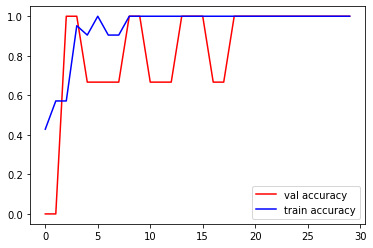

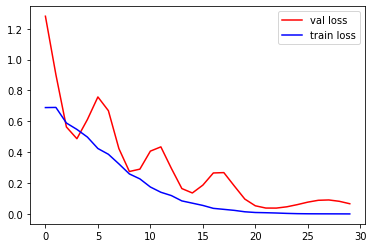

In [36]:
import matplotlib.pyplot as plt
print(history.__dict__)
#print(history.history)
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']
epochs = history.epoch 
plt.plot(epochs,val_accuracy,'r',label="val accuracy")
plt.plot(epochs,accuracy,'b',label="train accuracy")
plt.legend()

plt.figure()
val_loss = history.history['val_loss']
loss = history.history['loss']
plt.plot(epochs,val_loss,'r',label="val loss")
plt.plot(epochs,loss,'b',label="train loss")
plt.legend()
plt.show()